In [ ]:
import time
import base64
from IPython.display import Image, display

from hypha_rpc import connect_to_server,login
import os
import asyncio
import dotenv

dotenv.load_dotenv()  
ENV_FILE = dotenv.find_dotenv()  
if ENV_FILE:  
    dotenv.load_dotenv(ENV_FILE)  

server_url = "https://hypha.aicell.io"

reef_token = os.environ.get("REEF_WORKSPACE_TOKEN")
squid_token = os.environ.get("SQUID_WORKSPACE_TOKEN")

if not reef_token or not squid_token:
    token = await login({"server_url": server_url})
    reef_token = token
    squid_token = token
reef_server = await connect_to_server({"server_url": server_url, "token": reef_token, "workspace": "reef-imaging", "ping_interval": None})
squid_server = await connect_to_server({"server_url": server_url, "token": squid_token, "workspace": "squid-control", "ping_interval": None})


incubator_id = "incubator-control"
microscope_id = "microscope-control-squid-real-microscope-reef"
robotic_arm_id = "robotic-arm-control"

incubator = await reef_server.get_service(incubator_id)
microscope = await squid_server.get_service(microscope_id)
robotic_arm = await reef_server.get_service(robotic_arm_id)
print('connected')

In [ ]:
import asyncio
await incubator.initialize()
while await incubator.is_busy():
    await asyncio.sleep(1)

In [ ]:
## Any time you want to stop the robotic arm, you can run 'halt'
await robotic_arm.connect()
await robotic_arm.halt()


In [ ]:

sample_loaded = False

async def check_sample_loaded():
    global sample_loaded
    if sample_loaded:
        print("Sample plate has already been loaded onto the microscope")
    else:
        print("Sample plate is not loaded yet")

    return sample_loaded

async def load_plate_from_incubator_to_microscope(incubator_slot=33):
    """Load plate from incubator onto microscope."""
    global sample_loaded
    assert not sample_loaded, "Sample plate has already been loaded"
    await incubator.get_sample_from_slot_to_transfer_station(incubator_slot)
    while await incubator.is_busy():
        await asyncio.sleep(1)
    await microscope.home_stage()
    print("Plate loaded onto microscope.")
    await robotic_arm.connect()
    print("Robotic arm connected.")
    await robotic_arm.grab_sample_from_incubator()
    print("Sample grabbed.")
    await robotic_arm.transport_from_incubator_to_microscope1()
    print("Sample transported.")
    await robotic_arm.put_sample_on_microscope1()
    print("Sample placed on microscope.")
    await robotic_arm.disconnect()
    print("Robotic arm disconnected.")
    await microscope.return_stage()
    print("Sample plate successfully loaded onto microscope stage.")
    sample_loaded = True

async def unload_plate_from_microscope(incubator_slot=33):
    global sample_loaded
    assert sample_loaded, "Sample plate is not on the microscope"
    await robotic_arm.connect()
    # Move sample from microscope to incubator
    await microscope.home_stage()
    print("microscope homed.")
    await robotic_arm.grab_sample_from_microscope1()
    print("Sample grabbed from microscope.")
    await robotic_arm.transport_from_microscope1_to_incubator()
    print("Sample moved to incubator.")
    await robotic_arm.put_sample_on_incubator()
    print("Sample placed on incubator.")

    
    await incubator.put_sample_from_transfer_station_to_slot(incubator_slot)
    while await incubator.is_busy():
        await asyncio.sleep(1)
    print("Sample moved to incubator.")
    await microscope.return_stage()

    await robotic_arm.disconnect()
    print("Sample successfully unloaded from the microscopy stage")
    sample_loaded = False


In [ ]:
await load_plate_from_incubator_to_microscope(incubator_slot=33)

In [ ]:
microscope.scan_well_plate(do_reflection_af=True,scanning_zone=[(0,0),(7,11)], action_ID='testPlateScan')
#note: the imaging data will be saved on local harddisk

'The stage moved to home position in z, y, and x axis'

In [ ]:
await unload_plate_from_microscope()

'The stage moved to the initial position'

## Every time you want to stop the robotic arm, you can run 'halt'

In [12]:
robotic_arm.connect()
robotic_arm.halt()


True

In [2]:
def load_plate_from_incubator_to_microscope(incubator_slot=33):
    """Load plate from incubator onto microscope."""
    incubator.get_sample_from_slot_to_transfer_station(incubator_slot)
    while incubator.is_busy():
        time.sleep(1)
    microscope.home_stage()
    print("Plate loaded onto microscope.")
    robotic_arm.connect()
    print("Robotic arm connected.")
    robotic_arm.grab_sample_from_incubator()
    print("Sample grabbed.")
    robotic_arm.transport_from_incubator_to_microscope1()
    print("Sample transported.")
    robotic_arm.put_sample_on_microscope1()
    print("Sample placed on microscope.")
    robotic_arm.disconnect()
    print("Robotic arm disconnected.")
    microscope.return_stage()
    print("Plate loaded onto microscope.")

In [3]:
load_plate_from_incubator_to_microscope(incubator_slot=33)

Plate loaded onto microscope.
Robotic arm connected.
Sample grabbed.
Sample transported.
Sample placed on microscope.
Robotic arm disconnected.
Plate loaded onto microscope.


Move the microscope's stage to well A1, and snap an image

In [4]:
microscope.navigate_to_well('A',1,wellplate_type="96")
image = microscope.snap(exposure_time=28,channel=0,intensity=20)
print(image)

https://hypha.aicell.io/squid-control/apps/data-store-real-microscope/get?id=4b450a36-b6fe-4a09-905f-46da7113b32a


In [5]:
microscope.scan_well_plate(do_reflection_af=True,scanning_zone=[(0,0),(1,1)], action_ID='testPlateScan')

In [18]:
microscope.auto_focus()

#### Note: the sample was from last week and the cells are dead, we will have a live cell sample today.

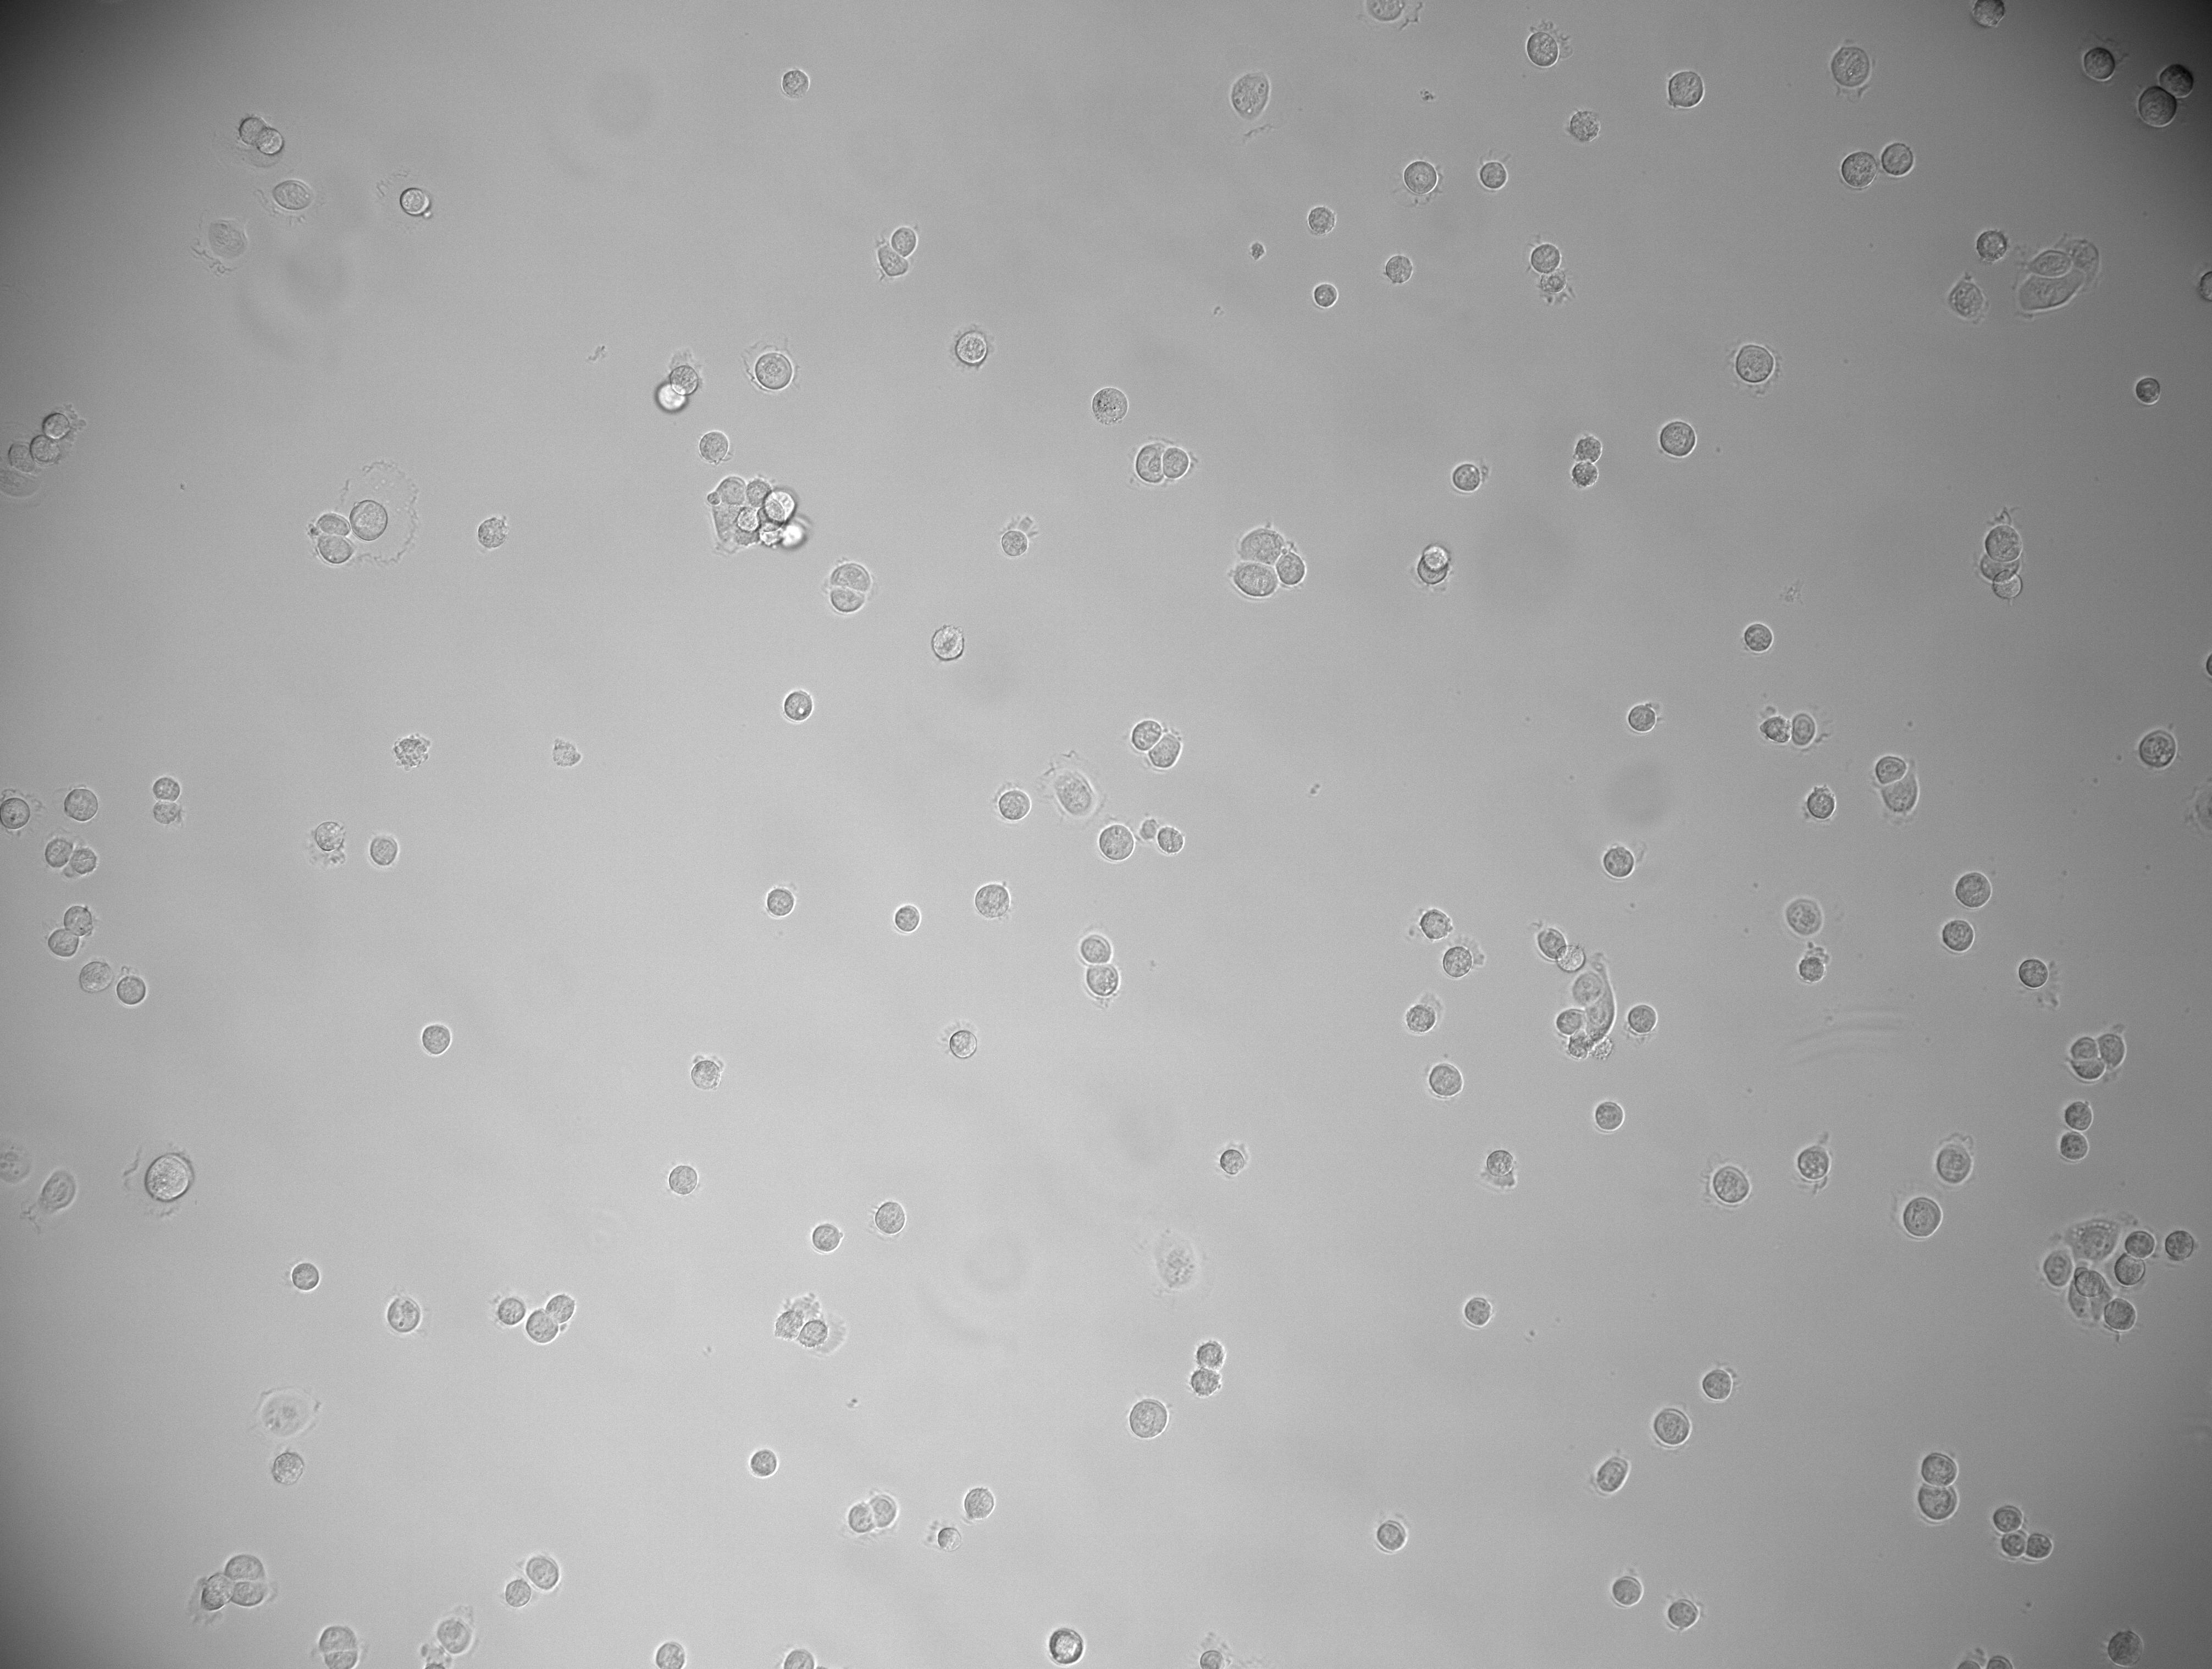

In [6]:
image_base64 = microscope.one_new_frame(exposure_time=28,channel=0,intensity=20)
img_data = base64.b64decode(image_base64)
display(Image(data=img_data))

### Put the sample back to incubator

In [2]:
def unload_plate_from_microscope(incubator_slot=33):

    robotic_arm.connect()
    # Move sample from microscope to incubator
    microscope.home_stage()
    print("microscope homed.")
    robotic_arm.grab_sample_from_microscope1()
    print("Sample grabbed from microscope.")
    robotic_arm.transport_from_microscope1_to_incubator()
    print("Sample moved to incubator.")
    robotic_arm.put_sample_on_incubator()
    print("Sample placed on incubator.")

    
    incubator.put_sample_from_transfer_station_to_slot(incubator_slot)
    while incubator.is_busy():
        time.sleep(1)
    print("Sample moved to incubator.")
    microscope.return_stage()

    robotic_arm.disconnect()

In [3]:
unload_plate_from_microscope()

microscope homed.
Sample grabbed from microscope.
Sample moved to incubator.
Sample placed on incubator.
Sample moved to incubator.
